In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from glob import glob
from IPython.display import clear_output
from src.data.synthetic_gen import DataLoader
from src.models.regression import NeuralNet
from src.models.regression.experiments import hparams
from src.models.regression.evaluate_models import RegressionAnalysis
from src.models.regression.train_models import RegressionTraining
from src.visualization.styles.formatting import errorbar_kwargs
from src.utils import denorm
from src.utils.constants import K_FOLDS

tf.random.set_seed(13)

In [2]:
generator_model_name = "Dirichlet Estimator"
dataset_sizes = [1, 2, 10, 50, 100]

training = RegressionTraining()
analysis = RegressionAnalysis()

results = training.load_training_models()
indices = analysis.load_performance_indices()

### Training best Neural Network

In [3]:
regressor_model_name = "Rede Neural #13"

output = [out for out in results["outputs"] if out["model_name"] == regressor_model_name][0]
model_id = [i for i, out in enumerate(results["outputs"]) if out["model_name"] == regressor_model_name][0]

print(f"Modelo: {output['model_name']}, ID: {model_id}")
print("    params:", output["params"])
print("    opt:   ", output["opt"])

Modelo: Rede Neural #13, ID: 12
    params: {'hidden_units': [128, 128, 128], 'activation': 'relu'}
    opt:    {'lr': 0.001, 'epochs': 500, 'batch_size': 32}


In [4]:
# Train best neural network
# Rede Neural #8
learning_rate = output["opt"]["lr"]
epochs = output["opt"]["epochs"]
batch_size = output["opt"]["batch_size"]

params = {"hidden_units": output["params"]["hidden_units"], "activation": output["params"]["activation"]}

for dataset_size in dataset_sizes:
    dl = DataLoader(problem="regression", model_name=generator_model_name, dataset_size=dataset_size)
    datasets, minmax = dl.load_cross_validation_datasets()

    train_data = datasets["train"]
    valid_data = datasets["valid"]

    models = []
    for i, (train, valid) in enumerate(zip(train_data, valid_data)):
        print(f"Running for dataset size: {dataset_size}, Fold: {i+1}")
        train_features, train_labels = train["features"], train["targets"]
        valid_features, valid_labels = valid["features"], valid["targets"]

        features, labels = train_features.values, train_labels.values
        train_ds = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(10000).batch(batch_size)

        features, labels = valid_features.values, valid_labels.values
        valid_ds = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

        loss_object = tf.keras.losses.MeanSquaredError()
        mae = tf.keras.metrics.MeanAbsoluteError()
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(),
            # patience 10% of epochs size
            tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=50),
        ]

        model = NeuralNet(**params)

        model.compile(optimizer=optimizer, loss=loss_object, metrics=[mae])
        h = model.fit(
            train_ds,
            epochs=epochs,
            validation_data=valid_ds,
            callbacks=callbacks,
            verbose=1,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
        )

        models.append(model)

        models_folder = os.path.join(
            "data",
            "models",
            "regression_with_synthetic_dataset",
            regressor_model_name,
            generator_model_name,
            f"{dataset_size}to1",
        )
        if not os.path.isdir(models_folder):
            os.makedirs(models_folder)

        model.save(os.path.join(models_folder, f"model_fold={i+1}.keras"))
        clear_output(wait=True)

Running for dataset size: 100, Fold: 4
Epoch 1/500
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - loss: 0.0397 - mean_absolute_error: 0.1250 - val_loss: 0.0032 - val_mean_absolute_error: 0.0316 - learning_rate: 0.0010
Epoch 2/500
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.0022 - mean_absolute_error: 0.0228 - val_loss: 0.0025 - val_mean_absolute_error: 0.0267 - learning_rate: 0.0010
Epoch 3/500
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.0016 - mean_absolute_error: 0.0186 - val_loss: 0.0015 - val_mean_absolute_error: 0.0199 - learning_rate: 0.0010
Epoch 4/500
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 9.2253e-04 - mean_absolute_error: 0.0138 - val_loss: 9.7138e-04 - val_mean_absolute_error: 0.0149 - learning_rate: 0.0010
Epoch 5/500
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 7.6083e-04 - mean_absolute_error: 0.0124 - val_loss: 9.8356e-04 - val_mean_absolute_error: 0.0162 - learning_rate: 0.0010
Epoch 6/500
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - los

### Evaluation

In [15]:
def mean_absolute_error(y_true: np.ndarray, y_pred: np.ndarray):
    return np.abs(y_true - y_pred).mean(axis=0)

def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray):
    return np.square(y_true - y_pred).mean(axis=0)

# Load saved models trained with synthetic dataset
def calculate_performances_values(folder, dataset_size, generator_model):
    print(f"Dataset {dataset_size}to1")
    
    dl = DataLoader(problem="regression", model_name=generator_model, dataset_size=dataset_size)
    datasets, min_max = dl.load_cross_validation_datasets()

    valid_data = datasets["valid"]
    models = [tf.keras.models.load_model(model_file) for model_file in glob(os.path.join(folder, "*.keras"))]
    mae, mse = [], []

    for i, (valid, model) in enumerate(zip(valid_data, models)):
        valid_features, valid_labels = valid["features"], valid["targets"]

        X_valid = tf.convert_to_tensor(valid_features)
        Y_valid = denorm(valid_labels.to_numpy(), *min_max[i])
        Y_hat_valid = denorm(model(X_valid).numpy(), *min_max[i])
    
        mae.append(mean_absolute_error(Y_valid, Y_hat_valid))
        mse.append(mean_squared_error(Y_valid, Y_hat_valid))

    mae = np.array(mae).mean(axis=1)
    mse = np.array(mse).mean(axis=1)

    print(f"MAE = {mae.mean():.2f} \\textpm {mae.std() / np.sqrt(K_FOLDS - 1):.2f}")
    print(f"MSE = {mse.mean():.2f} \\textpm {mse.std() / np.sqrt(K_FOLDS - 1):.2f}")
    print()

    return {
        "mae": mae, 
        "mse": mse
    }, {
        "mae": f"{mae.mean():.2f} \\textpm {mae.std():.2f}",
        "mse": f"{mse.mean():.2f} \\textpm {mse.std():.2f}"
    }

def create_results(generator_model_name, regressor_model_name):
    models_folder = glob(
        os.path.join(
            "data",
            "models",
            "regression_with_synthetic_dataset",
            regressor_model_name,
            generator_model_name,
            "*",
        )
    )
    models_folder = sorted(models_folder, key=lambda p: int(os.path.split(p)[-1].split("to")[0]))
    table = []

    print(f"Regressor: {regressor_model_name}, Gerador: {generator_model_name}")
    indices_dict = {}
    for folder in models_folder:
        dataset_size = int(os.path.split(folder)[-1].split("to")[0])
        values, table_values = calculate_performances_values(folder, dataset_size, generator_model_name)
        indices_dict[f"Sintético {dataset_size}x"] = values
        table.append(table_values)

    def highlight(s, props=""):
        if s.name == "num_params":
            return np.where(s == np.min(s.values), props, "")
        else:
            mu = s.apply(lambda row: float(row.split(r" \textpm ")[0]))
            return np.where(mu == np.min(mu.values), props, "")

    table = pd.DataFrame.from_records(table).style.apply(highlight, props="font-weight:bold;", axis=0)
    table.to_latex(
        os.path.join(
            "data",
            "models",
            "regression_with_synthetic_dataset",
            f"performance_indices_table_{generator_model_name}_{regressor_model_name}.tex",
        ),
        hrules=True,
        convert_css=True,
        column_format="lccccc",
    )
    return indices_dict

In [18]:
wgan_indices_dict = create_results(
    generator_model_name="WGAN #11", 
    regressor_model_name=regressor_model_name
)

Regressor: Rede Neural #13, Gerador: WGAN #11
Dataset 1to1
MAE = 2.34 \textpm 0.81
MSE = 152.21 \textpm 98.63

Dataset 2to1
MAE = 1.46 \textpm 0.37
MSE = 72.98 \textpm 57.89

Dataset 10to1
MAE = 1.61 \textpm 0.66
MSE = 91.32 \textpm 69.98

Dataset 50to1
MAE = 1.23 \textpm 0.62
MSE = 57.52 \textpm 53.71

Dataset 100to1
MAE = 1.03 \textpm 0.32
MSE = 26.02 \textpm 16.58



In [19]:
dirichlet_indices_dict = create_results(
    generator_model_name="Dirichlet Estimator", 
    regressor_model_name=regressor_model_name
)

Regressor: Rede Neural #13, Gerador: Dirichlet Estimator
Dataset 1to1
MAE = 1.76 \textpm 0.63
MSE = 100.64 \textpm 73.27

Dataset 2to1
MAE = 1.46 \textpm 0.42
MSE = 57.23 \textpm 39.57

Dataset 10to1
MAE = 1.21 \textpm 0.64
MSE = 84.85 \textpm 72.10

Dataset 50to1
MAE = 3.73 \textpm 3.15
MSE = 851.85 \textpm 847.42

Dataset 100to1
MAE = 1.53 \textpm 0.71
MSE = 105.30 \textpm 87.14



array([[0.505 , 0.6713, 0.4689, 2.526 ],
       [1.02  , 0.8641, 3.8454, 3.6121],
       [0.8724, 0.8161, 1.8114, 2.3387],
       [0.9893, 0.4934, 3.4905, 1.4689],
       [0.6511, 0.3259, 0.8985, 3.0592],
       [1.2396, 0.3116, 0.7814, 1.7996]])

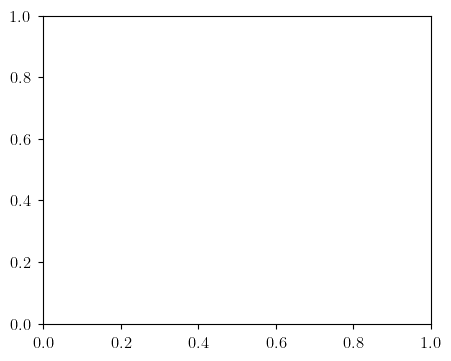

In [49]:
name = regressor_model_name.replace("#", "\#")
labels = [f"Real", *wgan_indices_dict.keys()]
x = np.arange(len(labels))

f, ax = plt.subplots(figsize=(5, 4))

wgan_mae = np.r_[
    [indices["mean_absolute_error"][:, model_id, :].mean(axis=1)], 
    np.array([i["mae"] for i in wgan_indices_dict.values()])
]
dirichlet_mae = np.r_[
    [indices["mean_absolute_error"][:, model_id].mean(axis=1)], 
    np.array([i["mae"] for i in dirichlet_indices_dict.values()])
]

wgan_mae

# wgan_y = wgan_mae.mean(axis=1)
# wgan_y_err = (wgan_mae.std(axis=1) / np.sqrt(K_FOLDS - 1))

# dirichlet_y = dirichlet_mae.mean(axis=1)
# dirichlet_y_err = (dirichlet_mae.std(axis=1) / np.sqrt(K_FOLDS - 1))

# ax.errorbar(x, wgan_y, wgan_y_err, label="SP (WGAN \#11)", c="tab:blue", **errorbar_kwargs)
# ax.errorbar(x, dirichlet_y, dirichlet_y_err, label="SP (Dirichlet)", c="tab:orange", **errorbar_kwargs)
# ax.errorbar([x[0]], [wgan_y[0]], [wgan_y_err[0]], label="SP (Real)", c="black", **errorbar_kwargs)
# ax.yaxis.grid()
# ax.set_xticks(x, labels, rotation=90, ha="center")
# ax.legend(loc="lower right")

# f.tight_layout()
# plt.savefig(os.path.join("data", "images", f"sp_index_errorbar_plot_synthetic_{classifier_model_name}.png"), dpi=600)
# plt.show()